# WorkflowSets with Time Series Cross-Validation - NEW Grouped API

This notebook combines WorkflowSet multi-model comparison with time series cross-validation for robust model selection on grouped panel data.

**NEW**: Uses `fit_nested()` to evaluate ALL workflows across ALL groups

## Contents:
1. Data loading and panel structure
2. Define multiple preprocessing strategies
3. Define multiple model specifications
4. Create WorkflowSet from cross product
5. **NEW**: Fit all workflows across all groups with fit_nested()
6. **NEW**: Collect and rank group-aware metrics
7. **NEW**: Compare workflows overall and per-group
8. Evaluate best workflow on test data
9. Visualize results

In [1]:
!pip install -e .

Obtaining file:///Users/matthewdeane/Documents/Data%20Science/python/_projects/py-tidymodels/_md
ERROR: file:///Users/matthewdeane/Documents/Data%20Science/python/_projects/py-tidymodels/_md does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# py-tidymodels imports
from py_workflows import workflow
from py_parsnip import linear_reg, rand_forest, boost_tree
from py_rsample import initial_split, training, testing, time_series_cv
from py_yardstick import metric_set, rmse, mae, r_squared
from py_tune import fit_resamples
from py_workflowsets import WorkflowSet

# Recipe imports
from py_recipes import recipe
from py_recipes.selectors import all_numeric_predictors
from py_visualize import plot_forecast

# Set random seed
np.random.seed(42)

print("✓ Imports complete")

✓ Imports complete


## 1. Data Loading

Load refinery margins panel data with multiple countries.

In [3]:
# Import data
raw_data = pd.read_csv('__data/refinery_margins.csv')
df = raw_data.copy()
df['date'] = pd.to_datetime(df['date'])

print(f"Data shape: {df.shape}")
print(f"Countries: {sorted(df['country'].unique())}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
display(df.head())

Data shape: (1920, 20)
Countries: ['Algeria', 'Denmark', 'Germany', 'Italy', 'Netherlands', 'Norway', 'Romania', 'Russian Federation', 'Turkey', 'United Kingdom']
Date range: 2006-01-01 00:00:00 to 2021-12-01 00:00:00


,date,country,refinery_kbd,brent,dubai,wti,brent_cracking_nw_europe,brent_hydroskimming_nw_europe,urals_cracking_nw_europe,urals_hydroskimming_nw_europe,es_sider_cracking_med,es_sider_hydroskimming_med,urals_cracking_med,urals_hydroskimming_med,dubai_cracking_singapore,dubai_hydroskimming_singapore,tapis_hydroskimming_singapore,x50_50_hls_lls_cracking_usgc,x30_70_wcs_bakken_cracking_usmc,bakken_coking_usmc
0,2006-01-01,Algeria,450.0000,63.57,58.31,65.48,3.12,-2.51,5.3,-2.18,4.81,-0.17,6.8,-1.52,2.47,-3.16,-1.79,-5.68,0.38,2.57
1,2006-01-01,Denmark,172.9948,63.57,58.31,65.48,3.12,-2.51,5.3,-2.18,4.81,-0.17,6.8,-1.52,2.47,-3.16,-1.79,-5.68,0.38,2.57
2,2006-01-01,Germany,2270.5419,63.57,58.31,65.48,3.12,-2.51,5.3,-2.18,4.81,-0.17,6.8,-1.52,2.47,-3.16,-1.79,-5.68,0.38,2.57
3,2006-01-01,Italy,1859.7058,63.57,58.31,65.48,3.12,-2.51,5.3,-2.18,4.81,-0.17,6.8,-1.52,2.47,-3.16,-1.79,-5.68,0.38,2.57
4,2006-01-01,Netherlands,907.5555,63.57,58.31,65.48,3.12,-2.51,5.3,-2.18,4.81,-0.17,6.8,-1.52,2.47,-3.16,-1.79,-5.68,0.38,2.57


In [4]:
# Train/test split
split = initial_split(df, prop=0.75, seed=123)
train_data = training(split)
test_data = testing(split)

print(f"Training: {train_data.shape[0]} rows")
print(f"Test: {test_data.shape[0]} rows")

Training: 1440 rows
Test: 480 rows


## 2. Define Multiple Preprocessing Strategies

Create different preprocessing approaches to compare.

In [5]:
# Strategy 1: Minimal formula (just one predictor)
formula_minimal = "refinery_kbd ~ brent"

# Strategy 2: Two predictors
formula_two = "refinery_kbd ~ brent + dubai"

# Strategy 3: All predictors
formula_all = "refinery_kbd ~ ."

# Strategy 4: Recipe with normalization
rec_normalized = (
    recipe()
    .step_normalize(all_numeric_predictors())
)

print("✓ 4 preprocessing strategies defined")

✓ 4 preprocessing strategies defined


## 3. Define Multiple Model Specifications

Create different model types to compare.

In [6]:
# Model 1: Linear Regression
spec_lr = linear_reg().set_engine("sklearn")

# Model 2: Random Forest
spec_rf = rand_forest(trees=100, mtry=3, min_n=5).set_mode("regression")

# Model 3: XGBoost
spec_xgb = boost_tree(trees=100, tree_depth=4, learn_rate=0.1).set_engine("xgboost")

print("✓ 3 model specifications defined")

✓ 3 model specifications defined


## 4. Create WorkflowSet from Cross Product

Combine all preprocessing strategies with all models.

In [7]:
# Create WorkflowSet
wf_set = WorkflowSet.from_cross(
    preproc=[
        formula_minimal,
        formula_two,
        formula_all,
        rec_normalized
    ],
    models=[
        spec_lr,
        spec_rf,
        spec_xgb
    ],
    ids=["minimal", "two_pred", "all_pred", "normalized"]
)

print(f"Created {len(wf_set.workflows)} workflows:")
for wf_id in wf_set.workflows.keys():
    print(f"  - {wf_id}")

Created 12 workflows:
  - minimal_linear_reg_1
  - minimal_rand_forest_2
  - minimal_boost_tree_3
  - two_pred_linear_reg_1
  - two_pred_rand_forest_2
  - two_pred_boost_tree_3
  - all_pred_linear_reg_1
  - all_pred_rand_forest_2
  - all_pred_boost_tree_3
  - normalized_linear_reg_1
  - normalized_rand_forest_2
  - normalized_boost_tree_3


## 5. Fit All Workflows Across All Groups

**NEW**: Use `fit_nested()` to fit all workflows on all groups, then use rank_results() for selection.

In [8]:
# Fit all workflows across ALL groups using NEW fit_nested() method
print(f"Fitting {len(wf_set.workflows)} workflows across {train_data['country'].nunique()} groups...")
print(f"Total models: {len(wf_set.workflows) * train_data['country'].nunique()}")
print()

# Use NEW WorkflowSet.fit_nested() method
results = wf_set.fit_nested(train_data, group_col='country')

print("\n✓ All workflows fitted across all groups")

Fitting 12 workflows across 10 groups...
Total models: 120

Fitting minimal_linear_reg_1 across all groups...
Fitting minimal_rand_forest_2 across all groups...
Fitting minimal_boost_tree_3 across all groups...
Fitting two_pred_linear_reg_1 across all groups...
Fitting two_pred_rand_forest_2 across all groups...
Fitting two_pred_boost_tree_3 across all groups...
Fitting all_pred_linear_reg_1 across all groups...
Fitting all_pred_rand_forest_2 across all groups...
Fitting all_pred_boost_tree_3 across all groups...
Fitting normalized_linear_reg_1 across all groups...
Fitting normalized_rand_forest_2 across all groups...
Fitting normalized_boost_tree_3 across all groups...

✓ All workflows fitted across all groups


## 6. Collect and Rank Results

**NEW**: Use group-aware methods to analyze performance.

In [9]:
# Collect metrics averaged across groups
metrics_avg = results.collect_metrics(by_group=False, split='train')

print("Average metrics across all groups:")
display(metrics_avg.head(12))

# Rank workflows by average RMSE
ranked_overall = results.rank_results('rmse', split='train', by_group=True, n=10)

print("\nTop 10 workflows (average RMSE across all groups):")
display(ranked_overall)

Average metrics across all groups:


,wflow_id,metric,split,mean,std,n,preprocessor,model
0,all_pred_boost_tree_3,mae,train,6.103944,4.877335,10,formula,boost_tree
1,all_pred_boost_tree_3,mape,train,0.730885,0.294032,10,formula,boost_tree
2,all_pred_boost_tree_3,mda,train,95.244755,1.641661,10,formula,boost_tree
3,all_pred_boost_tree_3,n_obs_train,train,144.000000,0.000000,10,formula,boost_tree
4,all_pred_boost_tree_3,r_squared,train,0.995064,0.002885,10,formula,boost_tree
5,all_pred_boost_tree_3,rmse,train,8.130476,6.365026,10,formula,boost_tree
6,all_pred_boost_tree_3,smape,train,1.003308,1.024629,10,formula,boost_tree
7,all_pred_linear_reg_1,adj_r_squared,train,0.462339,0.270905,10,formula,linear_reg
8,all_pred_linear_reg_1,breusch_pagan_p,train,0.228793,0.194462,10,formula,linear_reg
9,all_pred_linear_reg_1,breusch_pagan_stat,train,24.030456,8.229499,10,formula,linear_reg



Top 10 workflows (average RMSE across all groups):


,group,rank,wflow_id,value,preprocessor,model
0,Algeria,1,all_pred_boost_tree_3,6.759546,formula,boost_tree
1,Algeria,2,normalized_boost_tree_3,6.759546,recipe,boost_tree
2,Algeria,3,two_pred_boost_tree_3,32.932767,formula,boost_tree
3,Algeria,4,minimal_boost_tree_3,39.81789,formula,boost_tree
4,Algeria,5,normalized_rand_forest_2,41.018102,recipe,rand_forest
...,...,...,...,...,...,...
95,United Kingdom,6,minimal_boost_tree_3,82.855122,formula,boost_tree
96,United Kingdom,7,two_pred_rand_forest_2,84.389059,formula,rand_forest
97,United Kingdom,8,normalized_linear_reg_1,97.530405,recipe,linear_reg
98,United Kingdom,9,all_pred_linear_reg_1,97.530405,formula,linear_reg


In [10]:
# Rank workflows within each group
ranked_by_group = results.rank_results('rmse', split='train', by_group=True, n=3)

print("Top 3 workflows per group:")
display(ranked_by_group.head(30))

Top 3 workflows per group:


,group,rank,wflow_id,value,preprocessor,model
0,Algeria,1,all_pred_boost_tree_3,6.759546,formula,boost_tree
1,Algeria,2,normalized_boost_tree_3,6.759546,recipe,boost_tree
2,Algeria,3,two_pred_boost_tree_3,32.932767,formula,boost_tree
3,Denmark,1,all_pred_boost_tree_3,1.894563,formula,boost_tree
4,Denmark,2,normalized_boost_tree_3,1.894563,recipe,boost_tree
5,Denmark,3,two_pred_boost_tree_3,6.533499,formula,boost_tree
6,Germany,1,all_pred_boost_tree_3,10.492916,formula,boost_tree
7,Germany,2,normalized_boost_tree_3,10.492916,recipe,boost_tree
8,Germany,3,all_pred_rand_forest_2,51.643781,formula,rand_forest
9,Italy,1,all_pred_boost_tree_3,10.919774,formula,boost_tree


## 7. Visualize Workflow Comparison

**NEW**: Use autoplot() for group-aware visualization.

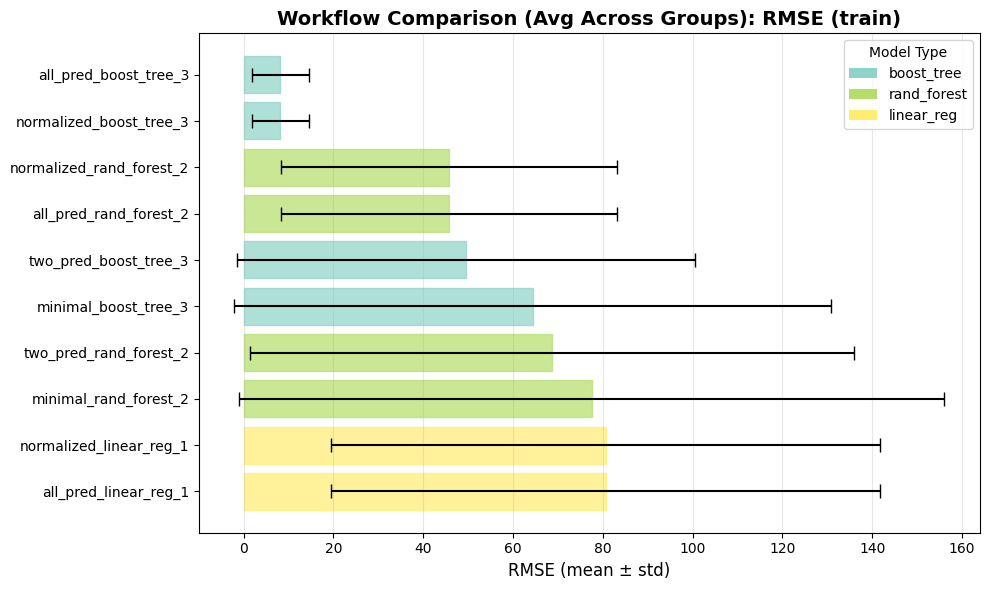


Shows average RMSE ± std across all groups


In [11]:
# Plot average performance with error bars
fig = results.autoplot('rmse', split='train', by_group=False, top_n=10)
plt.show()

print("\nShows average RMSE ± std across all groups")

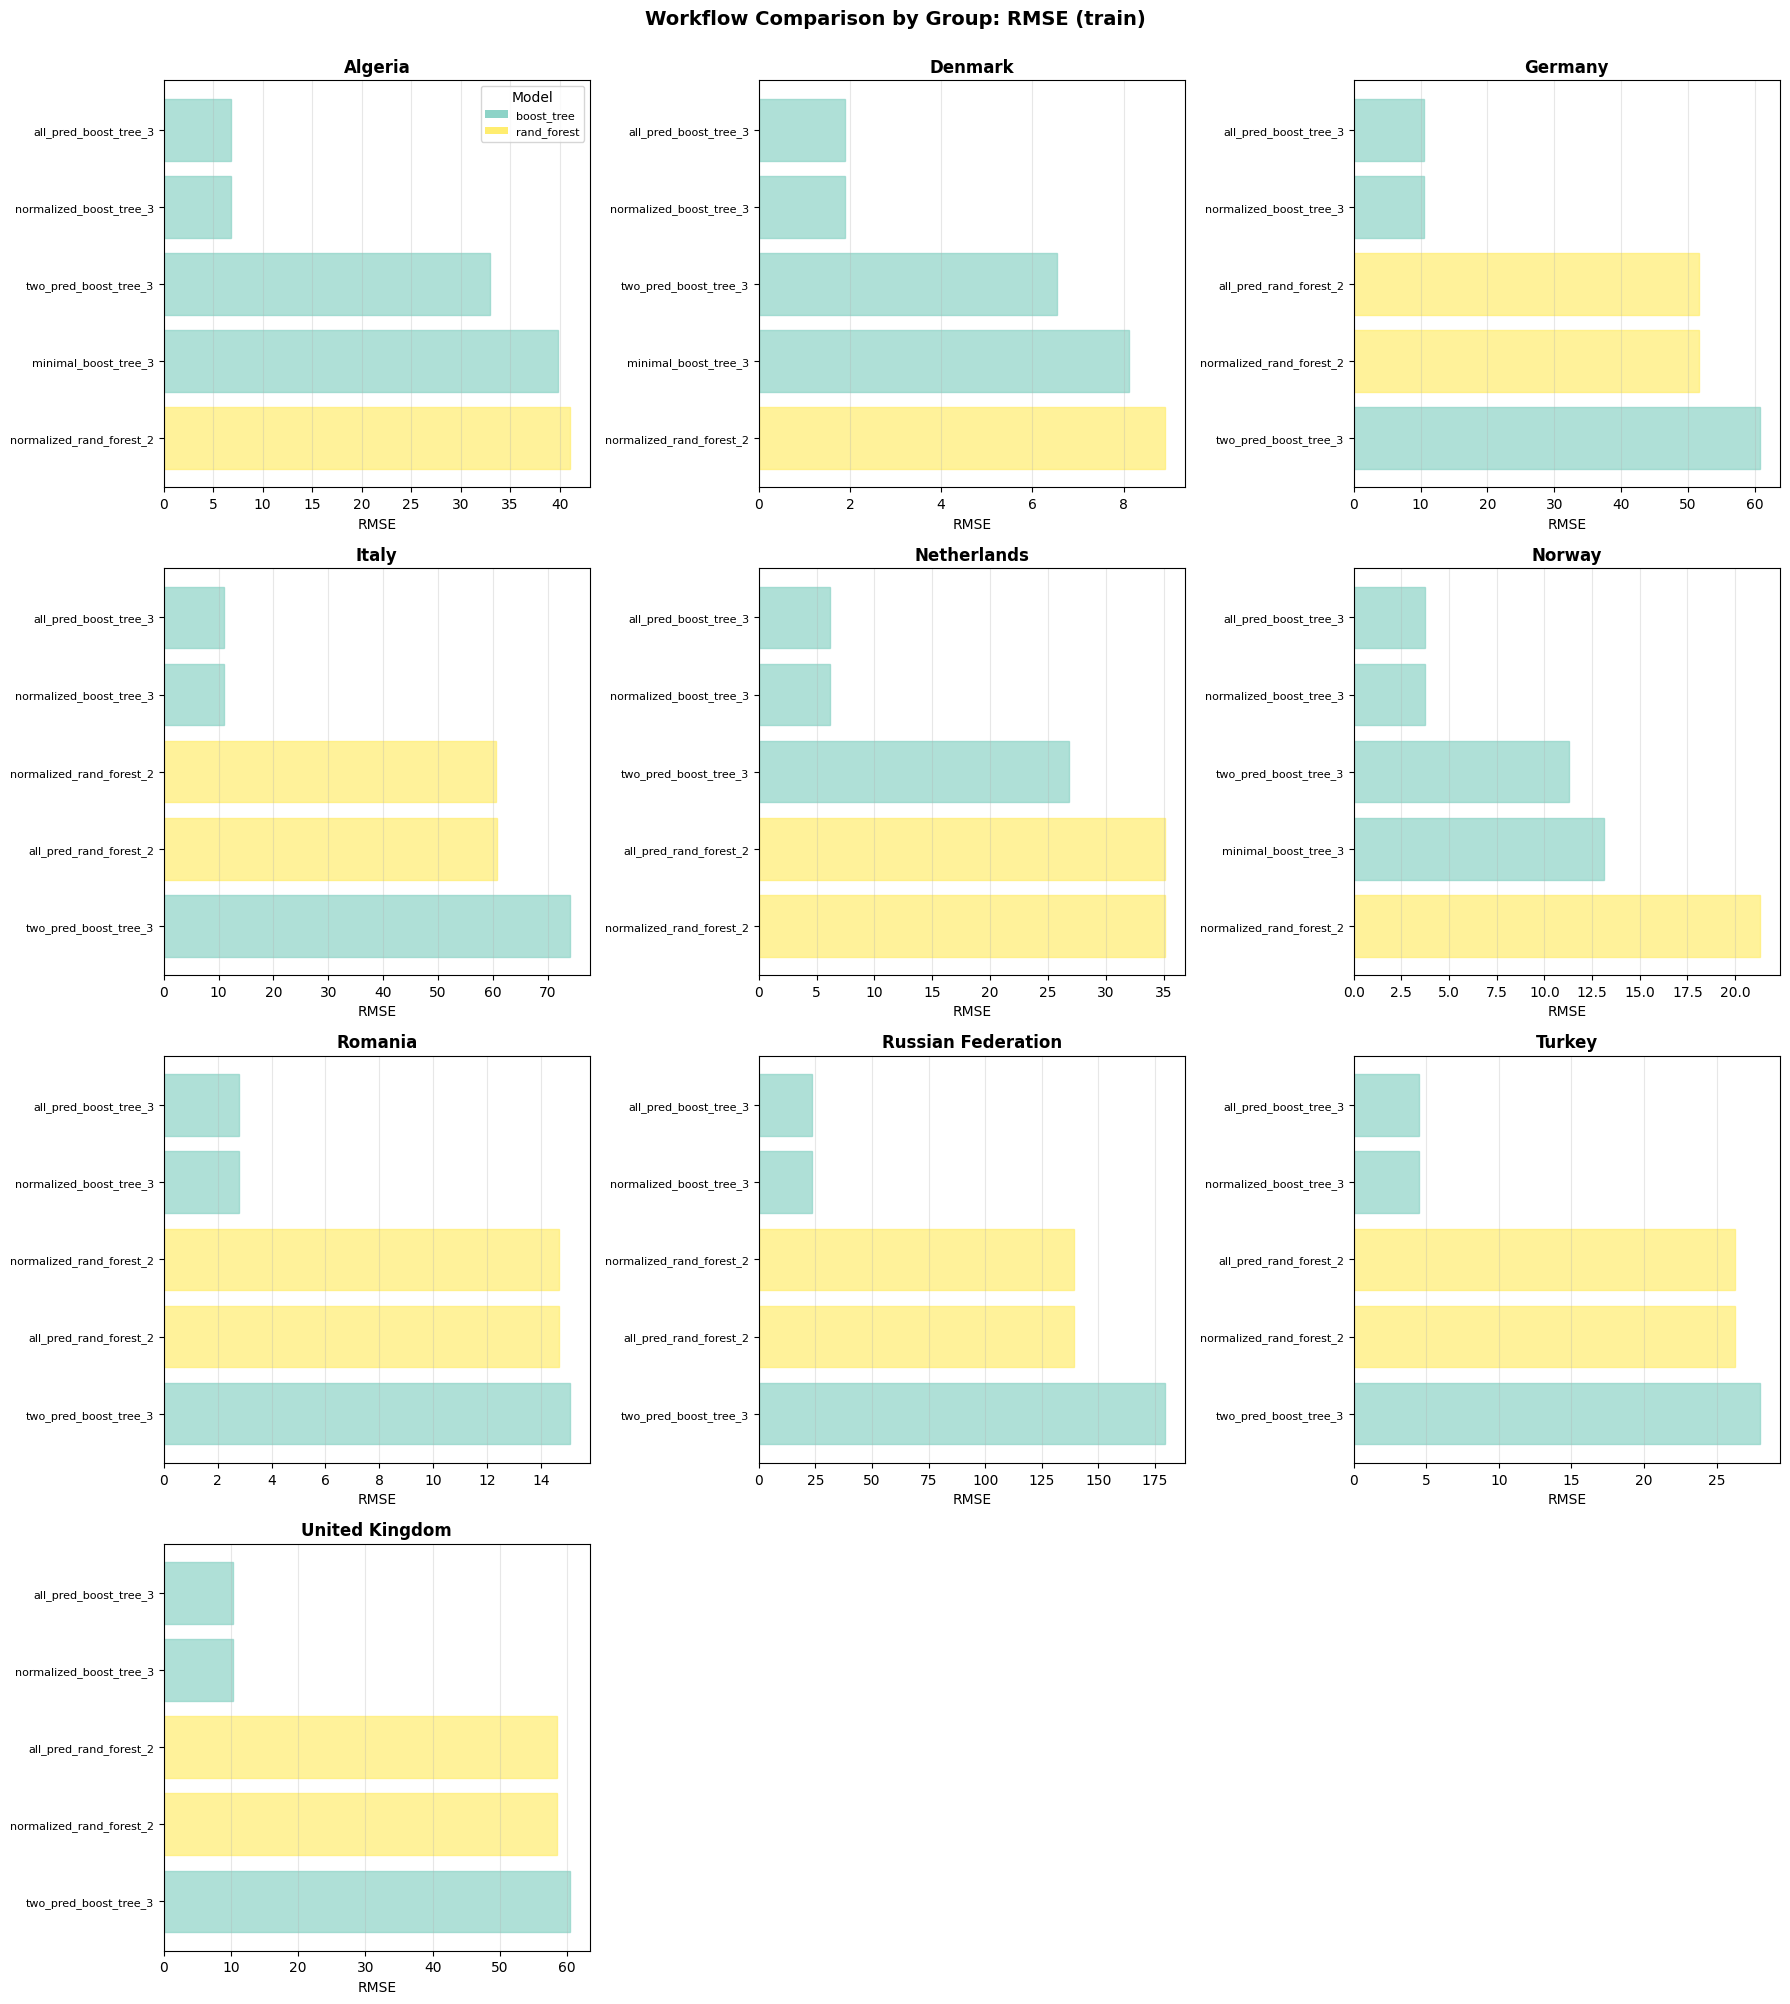


Shows top 5 workflows for each group separately


In [12]:
# Plot per-group performance
fig = results.autoplot('rmse', split='train', by_group=True, top_n=5)
plt.show()

print("\nShows top 5 workflows for each group separately")

## 8. Extract and Evaluate Best Workflow

Select best workflow and evaluate on test data.

In [13]:
# Get best workflow overall
best_wf_id = results.extract_best_workflow('rmse', split='train', by_group=False)

print(f"Best workflow (average across groups): {best_wf_id}")

# Also check per-group preferences
best_by_group = results.extract_best_workflow('rmse', split='train', by_group=True)

print("\nBest workflow per group:")
display(best_by_group)

Best workflow (average across groups): all_pred_boost_tree_3

Best workflow per group:


,group,wflow_id,value,preprocessor,model
0,Algeria,all_pred_boost_tree_3,6.759546,formula,boost_tree
1,Denmark,all_pred_boost_tree_3,1.894563,formula,boost_tree
2,Germany,all_pred_boost_tree_3,10.492916,formula,boost_tree
3,Italy,all_pred_boost_tree_3,10.919774,formula,boost_tree
4,Netherlands,all_pred_boost_tree_3,6.193416,formula,boost_tree
5,Norway,all_pred_boost_tree_3,3.737122,formula,boost_tree
6,Romania,all_pred_boost_tree_3,2.773761,formula,boost_tree
7,Russian Federation,all_pred_boost_tree_3,23.645365,formula,boost_tree
8,Turkey,all_pred_boost_tree_3,4.520746,formula,boost_tree
9,United Kingdom,all_pred_boost_tree_3,10.36755,formula,boost_tree


In [14]:
# Fit best workflow and evaluate on test
best_wf = wf_set.workflows[best_wf_id]

fit_nested = best_wf.fit_nested(train_data, group_col='country')
fit_nested = fit_nested.evaluate(test_data)

# Extract test stats
outputs, coefs, stats = fit_nested.extract_outputs()
test_stats = stats[stats['split'] == 'test']

# Pivot for display
test_stats_pivot = test_stats.pivot_table(
    index='group',
    columns='metric',
    values='value'
).reset_index()

print("\nTest performance by country:")
display(test_stats_pivot[['group', 'rmse', 'mae', 'r_squared']].sort_values('rmse'))

/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py_workflows/workflow.py:576: UserWarning: per_group_prep=True requires a recipe preprocessor. Workflow uses formula-only preprocessing. Falling back to per_group_prep=False.
  warnings.warn(



Test performance by country:


metric,group,rmse,mae,r_squared
1,Denmark,16.768963,11.080217,-0.430453
6,Romania,38.464743,29.290136,-0.275566
5,Norway,61.446624,48.26192,-0.852287
4,Netherlands,118.780208,93.67638,-0.475276
0,Algeria,145.335212,79.641596,0.010183
8,Turkey,204.233672,179.480374,-2.266074
3,Italy,217.426829,175.818265,-1.551963
2,Germany,242.756135,215.424132,-3.437233
9,United Kingdom,296.496795,266.022408,-4.52537
7,Russian Federation,458.840218,363.290615,-1.969957


## Summary

This notebook demonstrated **WorkflowSet grouped modeling with robust evaluation**:

### Key Features:
1. **`fit_nested()`** - Fit all workflows across all groups simultaneously
2. **`collect_metrics(by_group=False)`** - Average metrics across groups for ranking
3. **`rank_results()`** - Rank workflows overall and per-group
4. **`autoplot()`** - Visualize comparison with error bars
5. **`extract_best_workflow()`** - Select winning workflow

### Advantages Over Old Approach:

**Before:**
- Filter to ONE group (Germany)
- Run CV manually for each workflow
- Aggregate metrics manually
- Apply best to all groups separately

**After (NEW):**
- Fit ALL workflows on ALL groups
- Automatic metric aggregation
- Built-in ranking and visualization
- Single method call for complete evaluation

### Benefits:
- **More representative**: Uses all groups for selection, not just one
- **Detects heterogeneity**: Can identify if different groups need different workflows
- **Efficient**: Single API call vs manual loops
- **Robust**: Averages across groups reduce overfitting to single group

### Next Steps:
- Add hyperparameter tuning to best workflow
- Try `per_group_prep=True` for group-specific preprocessing
- Experiment with `fit_global()` for comparison
- Add time series CV within each group for even more robust evaluation